In [1]:
import os

def check_data():
    for dirname, _, filenames in os.walk('data'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            
check_data()

data/fashionmnist/t10k-images-idx3-ubyte
data/fashionmnist/fashion-mnist_test.csv
data/fashionmnist/t10k-labels-idx1-ubyte
data/fashionmnist/train-images-idx3-ubyte
data/fashionmnist/fashion-mnist_train.csv
data/fashionmnist/train-labels-idx1-ubyte


In [28]:
import torch

# For consistent result
torch.manual_seed(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [11]:
def output_label(label):
    output_mapping = [
        "T-shirt/Top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle Boot"
    ]
    
    index = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[index]
    

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

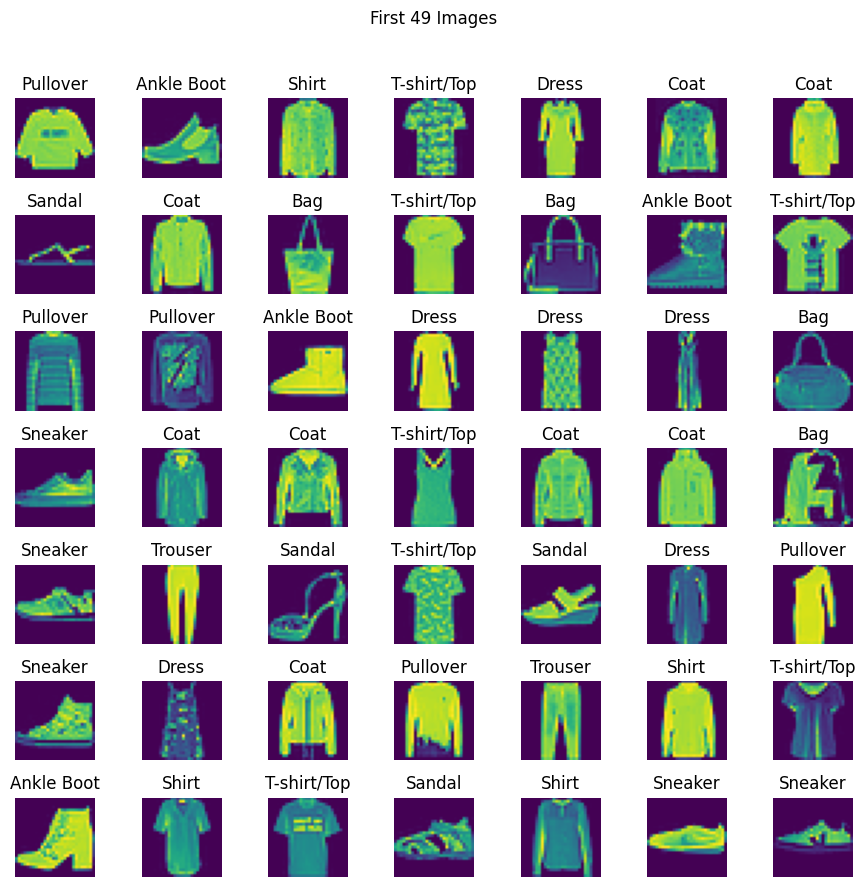

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

train_csv = pd.read_csv('data/fashionmnist/fashion-mnist_train.csv')
test_csv = pd.read_csv('data/fashionmnist/fashion-mnist_test.csv')

print(train_csv.head())
print('The shape of dataframe: ', train_csv.shape)

# Create a 7x7 grid of images
fig, axes = plt.subplots(7, 7, figsize=(9, 9))
fig.suptitle("First 49 Images", fontsize=12)

print(axes[0][0])

# Plot the first 49 images from the dataset
for i, ax in enumerate(axes.flat):
    img = train_csv.iloc[i, 1:].values.reshape(28, 28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{output_label(train_csv.iloc[i, 0])}")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [ ]:
from torch.utils.data import Dataset
from pandas import DataFrame
import numpy as np

class FashionDataset(Dataset):
    def __init__(self, data: DataFrame, transform = None):
        self.fashion_mnist = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        # [label, pixel0, .., pixel784]
        for i in self.fashion_mnist:
            label.append(i[0])
            image.append(i[1:])
        
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')
    
    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.images)
    

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

A train data size: torch.Size([100, 1, 28, 28])
The train set length: 60000
type of images: <class 'torch.Tensor'>, type of labels: <class 'numpy.int64'>
image shape: torch.Size([1, 28, 28]), label shape: ()


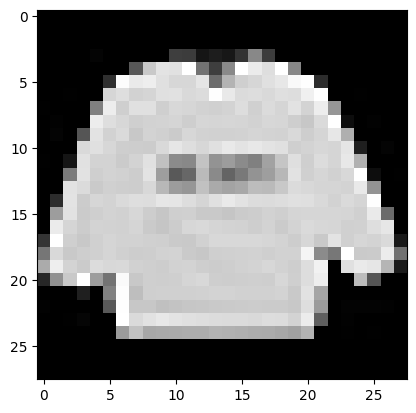

In [25]:
i = next(iter(train_loader))
print(f'A train data size: {i[0].size()}')
print(f'The train set length: {len(train_set)}')

image, label = next(iter(train_set))
print(f'type of images: {type(image)}, type of labels: {type(label)}')
print(f'image shape: {image.shape}, label shape: {label.shape}')
plt.imshow(image.squeeze(), cmap='gray')

In [23]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size = 10)

batch = next(iter(demo_loader))
images, labels = batch

print(f'type of images: {type(images)}, type of labels: {type(labels)}')
print(f'image shape: {images.shape}, label shape: {labels.shape}')

type of images: <class 'torch.Tensor'>, type of labels: <class 'torch.Tensor'>
image shape: torch.Size([10, 1, 28, 28]), label shape: torch.Size([10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


labels:  Pullover, Ankle Boot, Shirt, T-shirt/Top, Dress, Coat, Coat, Sandal, Coat, Bag, 

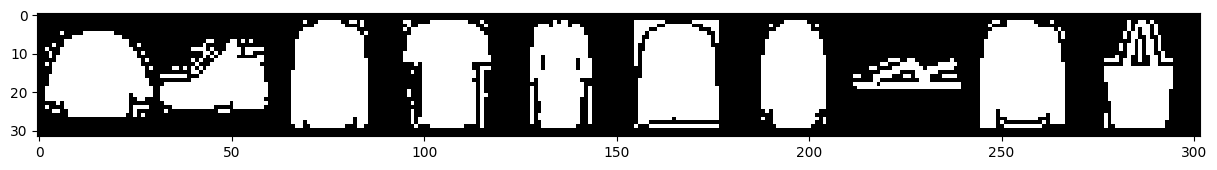

In [26]:
import torchvision

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [27]:
from torch import nn
from torch.nn import Module

class FashionCNN(Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)   
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = x
        out = self.layer1(out)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out
        

In [30]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [32]:
from torch.autograd import Variable

num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # transferring images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = error(outputs, labels)
        
        # initialize a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        count += 1
        
        if count % 50 == 0 :
            total = 0
            correct = 0
            
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                
                total += len(labels)
                
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if count % 500 == 0:
            print(f'Iteration: {count}, Loss: {loss.data}, Accuracy: {accuracy}%')

Iteration: 500, Loss: 0.42123210430145264, Accuracy: 89.5%
Iteration: 1000, Loss: 0.2407114952802658, Accuracy: 89.66999816894531%
Iteration: 1500, Loss: 0.25764012336730957, Accuracy: 90.31999969482422%
Iteration: 2000, Loss: 0.24332913756370544, Accuracy: 90.22000122070312%
Iteration: 2500, Loss: 0.19318963587284088, Accuracy: 91.0999984741211%
Iteration: 3000, Loss: 0.1661178469657898, Accuracy: 91.63999938964844%


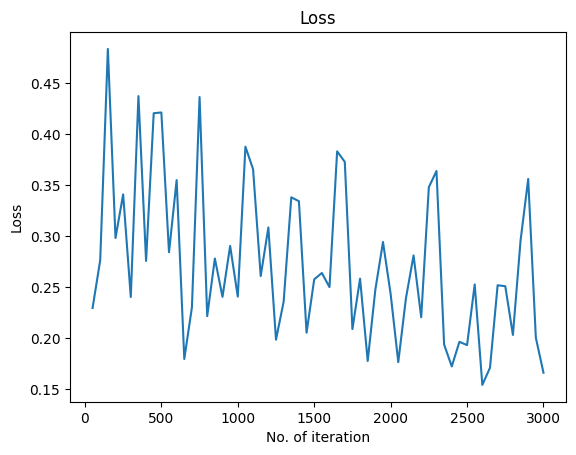

In [33]:
plt.plot(iteration_list, loss_list)
plt.xlabel('No. of iteration')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

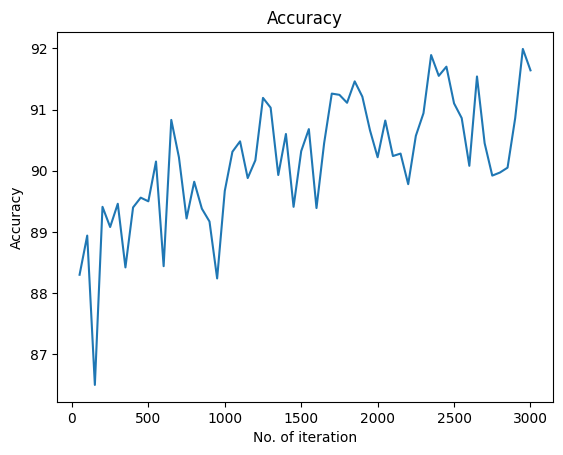

In [34]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel('No. of iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.show()

In [35]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

/Users/wonjulee/Desktop/workspace/study/studyAi/fashion-mnist/.venv/lib/python3.12/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of T-shirt/Top: 82.80%
Accuracy of Trouser: 98.80%
Accuracy of Pullover: 85.10%
Accuracy of Dress: 94.40%
Accuracy of Coat: 88.70%
Accuracy of Sandal: 95.70%
Accuracy of Shirt: 79.40%
Accuracy of Sneaker: 94.80%
Accuracy of Bag: 98.10%
Accuracy of Ankle Boot: 98.50%


In [36]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     60000
           1       0.98      0.98      0.98     60000
           2       0.85      0.86      0.86     60000
           3       0.89      0.91      0.90     60000
           4       0.87      0.84      0.86     60000
           5       0.98      0.96      0.97     60000
           6       0.74      0.71      0.72     60000
           7       0.94      0.95      0.94     60000
           8       0.97      0.98      0.97     60000
           9       0.95      0.96      0.96     60000

    accuracy                           0.90    600000
   macro avg       0.90      0.90      0.90    600000
weighted avg       0.90      0.90      0.90    600000


